# PROJECT: Course Optimization for Data Science 2022-2023
## Optimization strategies for the "smoothed" quantile regression with (non-)smooth penalties

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradient of a smoothed pinball loss used for quantile regression
- Implement your own solvers for L1 and L2 regularizations with: (Accelerated) Proximal gradient descent, proximal coordinate descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for L1 or L2 regularized smoothed-quantile regression model and test it on a real dataset where we will look at prediction invtervals.


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 2nd of January 2023 at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "zakaria"
ln1 = "echchair"
fn2 = "mohamed"
ln2 = "el fakir"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_echchair_zakaria_and_el fakir_mohamed.ipynb


Some imports

In [ ]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Part 1: Smoothed quantile regression model

[Quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) is a supervised learning regression model with target space $\mathcal{Y} = \mathbb{R}$. It is a method widely used in statistics to obtain prediction intervals, and it is very often used in time series forecasting.

We consider observations $x \in \mathbb{R}^{P}$. $P$ is the number of features, and we will denote the $N$ observations available in the training set as $x_1, \dots, x_N$.

We consider a linear model, _i.e.,_ we want to learn the parameters $\theta = (w, b) \in \mathbb{R}^{P}\times \mathbb{R}$ such that the value of $w^\top x + b$ is the $\tau$-quantile of the conditional distribution $y | x$. For example, for $\tau=0.5$, we want to learn the parameters such that the value of $w^\top x + b$ is the *median* of the conditional distribution $y | x$. For $\tau=0.9$, we want to learn the parameters such that the value of $w^\top x + b$ is the *90th percentile* of the conditional distribution $y | x$, meaning that 90% of the observations of $y | x$ are below $w^\top x + b$.

An estimate $\hat{q}$ of the $\tau$-conditional sample quantile is obtained by minimizing the following loss function:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N
    \left[
            (\tau - 1) \mathbb{1}_{\{y_i < q\}} (y_i - q) + 
            \tau \mathbb{1}_{\{y_i \geq q\}} (y_i - q)
    \right]
$$

The function $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z)$ is known as the **pinball loss**. The above loss can then be rewritten as:
$$
\hat{q} = \arg\min_{q}
    \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - q) \enspace.
$$
The optimization problem becomes:
$$
\hat{w}, \hat{b} = \arg\min_{w, b} L(w, b)
    \enspace \mathrm{with} \enspace L(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau(y_i - w^\top x_i - b)
$$

Introducing some regularization on the parameter $w$ with parameter $\lambda \ge 0$, the penalized estimation problem is written:

$$
    (\mathcal{P}^{\mathcal{R}}):
	\min_{w \in \mathbb{R}^P, b \in \mathbb{R}} \quad L(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be :
- $\mathcal{R}_1(w) = \|w\|_1 = \sum_{j=1}^P |w_{j}|$, ie. an $\ell_1$ norm
- $\mathcal{R}_2(w) = \|w\|_2^2 = \sum_{j=1}^P w_{j}^2$, ie. a squared $\ell_2$ norm

Here is an implementation of the pinball loss:

In [ ]:
def pinball(z, tau=0.5):
    """Compute the pinball loss for z and a quantile tau.

    Parameters
    ----------
    z : ndarray, shape (n_samples,)
        The values on which to compute the pinball loss.
    tau : float in [0, 1]
        The quantile.
    
    Returns
    -------
    loss : ndarray, shape (n_samples,)
        The value of the pinball loss for each value of z.
    """
    sign = (z >= 0).astype(z.dtype)
    loss = tau * sign * z - (1 - tau) * (1 - sign) * z
    return loss

#### QUESTION 0

- Plot the pinball loss for tau=0.3, 0.5 and 0.7.

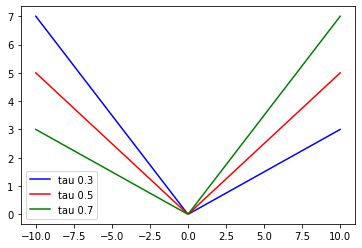

In [ ]:
### TODO

x = np.linspace(-10,10,200)

y1 = pinball(x,0.3)
y2 = pinball(x,0.5)
y3 = pinball(x,0.7)

plt.plot(x, y1, "-b", label="tau 0.3")
plt.plot(x, y2, "-r", label="tau 0.5")
plt.plot(x, y3, "-g", label="tau 0.7")
plt.legend(loc="best")


### END TODO

#### QUESTION 1:

- Justify that $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex optimization problems.
- Can you readily apply gradient descent or proximal gradient descent to solve these two problems? You will justify your answer by commenting on the smoothness of the objective functions.





**ANSWER HERE**
### 1-1
To justify that  $(\mathcal{P}^{\mathcal{R}_1})$ and  $(\mathcal{P}^{\mathcal{R}_2})$ are convex problems, we need to prove that each problem is sum of two convex functions, to do so we need to prove that is $\ell_\tau^\delta(z)$ convex :

we have : $\ell_\tau(z) = (\tau - 1) \mathbb{1}_{\{z \leq 0\}} (z) + \tau \mathbb{1}_{\{z \geq 0\}} (z) \iff \ell_\tau(z) = -(\tau - 1) max(0,-z) + \tau \ max(0,z) $.

Also, we know that $ϕ(z) = max(z_1,z_2)$ is a convex function, so $\ell_\tau(z)$ satisfies Jensen inequality because $\ell_\tau(z)$ is sum of two convex functions with positives coefficients.

On another hand, $R_2$ is strongly convex because it's hessian is positive definite. And the $R_2$ is convex due to the triangular inequality that satisfies Jesen inequality.

As we have $\ell_\tau(z)$, $R_2$ and $R_1$ are all convex so the sum of different terms are convex. As result, $(\mathcal{P}^{\mathcal{R}_1})$ and $(\mathcal{P}^{\mathcal{R}_2})$ are convex, so we have convex problems.
### 1-2
- For both problems the pinball loss isn't smouth, so the sum of a non smouth function with another function isn't smouth so the two problems here aren't smouth, which eliminate the gradient descent, because it won't be effective . IN fact Gradient descent is an optimization algorithm that relies on the smoothness of the loss function in order to work effectively. If the loss function is not smooth, it can be difficult for the algorithm to make progress because the gradient at any given point may not accurately reflect the direction of the steepest descent. This can cause the algorithm to oscillate or even diverge instead of converging to the optimal solution.
- However, for the second problem, we have a regularization term which is smouth and the pinball loss which is convex and not smouth, so we have the requirements to use proximal gradient descent, but with L2 norm as the F(w) function and pinball loss as the R(w) function

Let us illustrate what type of solution one obtains when minimizing the pinball loss. For now, we will use a black-box optimization method from `scipy`.

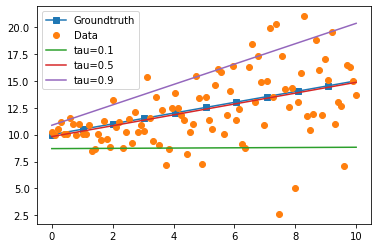

In [ ]:
import numpy as np
from scipy.optimize import minimize

rng = np.random.RandomState(42)
x = np.linspace(start=0, stop=10, num=100)
X = x[:, np.newaxis]  # make X two-dimensional with one column
y_true = 10 + 0.5 * x
y = y_true + rng.normal(loc=0, scale=0.5 + 0.5 * x, size=x.shape[0])

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
tau = 0.3

def pobj(wb, tau):
    w, b = wb[:1], wb[-1]
    return np.mean(pinball(y - X @ w - b, tau=tau))

for tau in [0.1, 0.5, 0.9]:
    w_hat, b_hat = minimize(lambda wb : pobj(wb, tau), x0=[0, 0]).x
    plt.plot(x, x * w_hat + b_hat, label=f"tau={tau}")

plt.legend()

One can observe that the predictions obtained with 0.1 and 0.9 form an interval that can be used to evaluate the uncertainty of the prediction.

## Smoothed pinball loss

Let us define the function:

$$
    \ell_\tau^\delta(z) = \min_{u \in \mathbb{R}} \quad
    \underbrace{
        \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2
    }_{J(u)}
$$

#### QUESTION 2:
- Justify that the function $\ell_\tau^\delta: z \rightarrow \ell_\tau^\delta(z)$ is well defined, meaning that a unique function value exists for each value of z.
- Prove that for any $\delta >0$, we have $\ell_\tau^\delta(z) \leq \ell_\tau(z)$.
- Prove that the function $\ell_\tau^\delta$ is given by the formula just below:

$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

**ANSWERS :**
- the $\ell_\tau(u)$ is a convex function, and $\tfrac{1}{2\delta} (z - u)^2$ is a 1/$\delta$-strongly convex function, so the sum of them is a strongly convex function, so for each $z$ there is a unique minima , then the function is well defined

- we have $\ell_\tau^\delta(z) \leq J(u)$ for $u \in \mathbb{R}$, so particulary for $u=z$ we have $\ell_\tau^\delta(z) \leq J(u)=J(z)= \ell_\tau(z)$


- To prove the relation above we need to establish the minimum of $ \ell_\tau^\delta (z) $ (1) according to each value of $u$ :

$$\ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\min_{u}(\tau u + \frac{1}{2 \delta}(u-z)^2) \quad \mathrm{ if } \quad  u > 0 \\
	\min_{u}((\tau-1) u + \frac{1}{2 \delta}(u-z)^2) \quad u<0 \\
	\frac{z^2}{2 \delta} \quad \mathrm{ if } \quad  u=0 
	\end{aligned}
    \right. \quad \quad \quad (1) \\
$$


Let's denote $J(u) = \ell_\tau(u) + \tfrac{1}{2\delta} (z - u)^2 = (\tau - 1) \mathbb{1}{\{u \leq 0\}} (u) + \tau \mathbb{1}{\{u \geq 0\}} (u) + \tfrac{1}{2\delta} (z - u)^2 $, so : 



$$\\
 J'(u) = \left\{
	\begin{aligned}
	\tau + \frac{1}{\delta}(u-z)  \quad \mathrm{ if } \quad  u > 0 \\
	(\tau-1) + \frac{1}{\delta}(u-z) \quad \mathrm{ if } \quad u<0 \\
	\partial{\ell_\tau(u) } + \frac{1}{\delta}(-z) \quad \mathrm{ with} \quad \partial{\ell_\tau(u) }\in [\tau-1,\tau] \quad \mathrm{ if } \quad  u=0
	\end{aligned}
    \right.\\
$$



So  for $J'(u)=0$, we have : 



$$
 J'(u) = 0 \iff \left\{
	\begin{aligned}
	u = z - \tau \delta   \quad \mathrm{ if } \quad  u > 0 \\
	u = z - (\tau-1)\delta  \quad \mathrm{ if } \quad u<0 \\
	0 \in \partial{\ell_\tau(u) } + \frac{1}{\delta}(-z) \quad \mathrm{ with} \quad \partial{\ell_\tau(u) }\in [\tau-1,\tau] \quad \mathrm{ if } \quad  u=0
	\end{aligned}
    \right.
\\ \\
 \iff \left\{
	\begin{aligned}
	u = z - \tau \delta   \quad \mathrm{ if } \quad  z > \tau \delta \\
	u = z - (\tau-1)\delta  \quad \mathrm{ if } \quad z<(\tau-1)\delta \\
	u = 0 \quad \mathrm{ if } \quad  z \in [\delta(\tau-1), \delta \tau]
	\end{aligned}
    \right. \quad \quad \quad (2)
$$



Therefor, we deduce the following according to $(1)$ and $(2)$ (we replace $u$ by its value according to each interval)  :



$$
    \ell_\tau^\delta (z) = \left\{
	\begin{aligned}
	\tau (z - \frac{\delta \tau}{2}) & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z^2}{2 \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (1-\tau) \left( -z - \tfrac{\delta}{2} (1 - \tau) \right) & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

#### QUESTION 3:
- Implement the function `smooth_pinball(z, tau, delta)` that applies $\ell_\tau^\delta$ to each entry a numpy array. You will plot the function `smooth_pinball` and `pinball` between -2 and 2.

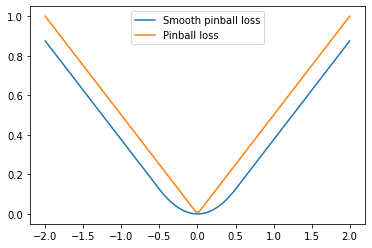

In [ ]:
def smooth_pinball(z, tau , delta ):
    """Compute the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    l : array-like, shape (n_samples,)
        The smoothed pinball loss values.
    """
    out = z.copy().astype(np.float64)
    ### TODO


    F1=tau*(z - (tau*delta)/2)
    F2=z**2/(2*delta)
    F3=(1-tau)*(-z- (delta/2)*(1-tau))
    out=F1*(z >= tau*delta ) +F2* (z >= -delta*(1-tau)) * (z < tau*delta)  +F3*(z< -delta*(1-tau))

    ### END TODO
    return out
    

### TODO plotting

z = np.linspace(-2, 2, 100)

# Compute smooth pinball loss for tau=0.5 and delta=1
smooth_loss = smooth_pinball(z, tau=0.5, delta=1)

# Compute pinball loss for tau=0.5
pinball_loss = pinball(z, tau=0.5)

# Plot smooth pinball loss and pinball loss
plt.plot(z, smooth_loss, label="Smooth pinball loss")
plt.plot(z, pinball_loss, label="Pinball loss")
plt.legend()
### END TODO

#### QUESTION 4:
- What is the derivative of the smoothed pinball loss $\ell_\tau^\delta$?
- Justify that the derivative of the smoothed pinball loss is continuous.
- Justify that the function $\ell_\tau^\delta$ is L-smooth. Propose a value for the Lipschitz constant of its gradient.
- Justify that the function $\ell_\tau^\delta$ is convex. Is it strongly convex?
- Implement the function `grad_smooth_pinball(z, tau, delta)` that applies the derivative of $\ell_\tau^\delta$ to each entry of a numpy array.

**Remark:** You will use the `scipy.optimize.check_grad` function to assess the validity of your result. You will need to test your gradient in both the linear and quadratic regions of the function (not just in one location).

- The derivative of the smoothed pinball is :
$$
    \ell_\tau^\delta \text' (z) = \left\{
	\begin{aligned}
	\tau & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{z}{\delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{z}{ \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    (\tau -1)  & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

- In the limit where $z^+$ close from $\tau \delta$ we have derivative equals to $\tau$. However when $z$ close to $0$ we have from right and from left : the derivative equals to $0$ . Moreover, when in the left limit of $z^-$ close from $-\delta (1 - \tau)$ , the derivative will be $(\tau-1)$. => so the the derivative of the smoothed pinball loss is continuous.

- The derivative of pinball is continuous so it's differentiable, and it's second derivative is:
$$
    \ell_\tau^\delta  \text''' (z) = \left\{
	\begin{aligned}
	0 & \quad \mathrm{ if } \quad  \delta \tau \leq z \\
	\frac{1}{\delta} & \quad \mathrm{ if } \quad 0 \leq z < \tau \delta \\
	\frac{1}{ \delta} & \quad \mathrm{ if } \quad  -\delta (1 - \tau) \leq z < 0 \\
    0  & \quad \mathrm{ otherwise }
	\end{aligned}
    \right.
$$

  The one can easily conclude that $\ell_\tau^\delta$$'' \leq \frac{1}{\delta}$

- Yes, it is convex because $ 0 \leq$ $\ell_\tau^\delta$$''$

- no it's not strongly convex because we can't find a quadratic underboud that minimize it. Indeed we have $\ell_\tau^\delta$$''$ can be equal to $0$ when  $\delta \tau \leq z$. So it isn't strincly bigger than 0. => non strongly convex .




Check gradient : 3.706560300486854e-15


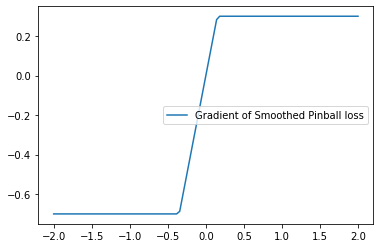

In [ ]:
def grad_smooth_pinball(z, tau, delta):
    """Compute the derivative of the smoothed pinball loss
    
    Parameters
    ----------
    z : array-like, shape (n_samples,)
        The array on which to compute the smoothed pinball loss.
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    dl : array-like, shape (n_samples,)
        The derivative of smoothed pinball loss computed element-wise.
    """
    out = z.copy().astype(np.float64)
    ### TODO
    out = np.where(out < -delta*(1-tau), tau-1, 
           np.where(out > tau*delta, tau, out/delta))
    ### END TODO
    return out

x = np.linspace(-2, 2, 100)
tau = 0.3
delta = 1
plt.plot(x, grad_smooth_pinball(x, tau=tau, delta=0.5), label='Gradient of Smoothed Pinball loss')
plt.legend();

from scipy.optimize import check_grad

### TODO check gradient with check_grad function.
check = np.array([ check_grad(smooth_pinball, grad_smooth_pinball, i,tau, delta ) for i in x])
print('Check gradient :', np.sum(check.T@check))
### END TODO

From now on, we consider the following optimization problem:

$$
    (\mathcal{P}_\delta^\mathcal{R}): \min_{w, b} \quad L_\delta(w, b) + \lambda \mathcal{R}(w)
$$

where $\mathcal{R}(w)$ can be $\mathcal{R}_1(w)$ or $\mathcal{R}_2(w)$, and where $L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$.

#### QUESTION 5:
- Justify what optimization strategy among L-BFGS, (proximal-)gradient descent, (proximal-)coordinate descent is readily applicable
  for $(\mathcal{P}_\delta^{\mathcal{R}_2})$ and $(\mathcal{P}_\delta^{\mathcal{R}_1})$.

*ANSWER HERE*

we have : $\enspace L_\delta(w, b) = \frac{1}{N} \sum_{i=1}^N \ell_\tau^\delta(y_i - w^\top x_i - b)$
So the Heassian is :
$\enspace L_\delta''(w, b) = \frac{1}{N} \sum_{i=1}^N  \ell_\tau^\delta$$''$$(y_i - w^\top x_i - b) x_i  x_i^\top$ $=\frac{1}{N} X  D X^\top$
With $D$ is diagonale such that $D_{ii}=\ell_\tau^\delta$$''$$(y_i - w^\top x_i - b) \leq \frac{1}{\delta}$

Therefore : $L_\delta$''$(w, b) \leq \frac{1}{N} \sigma_{max}(X D X^\top)\leq \frac{1}{N \delta} \sigma_{max}^2(X) I_p $ 
And the derivative of L with respect to $b$ is upperbounded by $\frac{1}{\delta}$



Let's see what are the features of our problem

|       |   R2    |    R1   | 
|---    |:-:    |:-:    |
|Convexity    |  Sum of two convex functionns is convex   |Same thing    |    
|Strongly convex    |Pinball is convex + L2 which is $\lambda$ -strongly <br />convex . SO the whole function is strongly convex with $\mu = \lambda$    |  not strongly convex because pinball isn't strongly convex neither the L1   |     
|Smouthness    |Both functions are smooth, so the corresponding smoothness constant is the sum: $L+\lambda$     |smooth function + convex and non smooth function = non smooth function|      

- So the possibilities are


|       |  R2     |    R1   |         
|---    |:-:    |:-:    |
| Gradient Descent      | Convex + smooth. => So it will converge and it's okey  |Convex + non smooth => Won't be efficient and it will diverge when become close to min       |
|  Prox GD   |  If we take the prox function as Identity we will have the gradient descent which is working     |Smooth and convex F + Convex and easy to optimize L1 ==> Possibility of using proximal since all assumptions are present      |
|   Coordinate descent    | same assumption as gradient descent but will work better if the $Nfeatures \geq Nsamples$   | It's not possible since the function isn't smooth           |
|   Prox CD   |R2 is separable, so we can use Prox CD and it meets the requirements| Same thing since R1 separable       |
|   L-BFGS  |The function is 2 times differentiable and it's Heassian is positive definite so we can use it, | It will work very slow, since the L1 isn't twice differentiable everywhere, so the <br />estimation of the Heassian isn't precise and it will be very difficult to estimate coefficients at 0 precision    |

- For L2 problem: we could use gradient descent which is expensive in terms of iteration cost but it get very close to the solution after enough iterations especially in the case when number of samples greater than number of features, else we know that coordinates descent would be a better fit. Moreover newton method needs the initial point to be in specific range to converges but thanks to the line search and other approaches in L-BFGS , it can converge at better cost.

- For L1 problem:  we can only use proximal gradient descent  which converges for sure, and same as before when the $Nfeature \geq Nsamples$ the coordinates descent performes better.

#### QUESTION 6:
- Solve the optimization prolem $(\mathcal{P}_\delta^{\mathcal{R}_2})$ using the `fmin_l_bfgs_b` function from `scipy.optimize`. You are expected to provide the explicit gradient (fprime parameter) to `fmin_l_bfgs_b`.
- Using the simulated dataset from above, you will check that your solver gives comparable results as obtained above without smoothing when setting a very small value for $\lambda$. Your are expected to make a plot of the regression fit.

The estimate of $w$ and $b$ should be called `w_hat` and `b_hat`. You will call the regularization parameter $\lambda$ as `lbda` in the code.

To help you, we provide you with the function `pobj_l2` that computes the objective to minimize. Note that the parameters `w` and `b` are combined in a single array `params`.

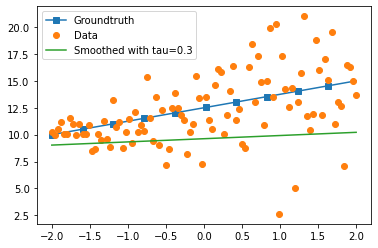

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

lbda = 0.01
delta = 0.5

def pobj_l2(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Objective function with L2 penalty."""
    w = params[1:]
    b = params[0]
    residual = y - np.dot(X, w) - b
    return np.mean(smooth_pinball(residual, tau=tau, delta=delta)) + lbda * np.sum(w ** 2)


def smooth_pinball_lbfgs_l2(X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    """Estimate w and b using L-BFGS.
    
    Parameters
    ----------
    X : ndarray, shape (n_samples, n_features)
        The array of features.
    y : ndarray, shape (n_samples,)
        The target.
    lbda : float
        The regularization parameter lbda
    tau : float in [0, 1]
        The quantile.
    delta : float
        The smoothing parameter.
    
    Returns
    -------
    w_hat : ndarray, shape (n_features,)
        The estimated w.
    b_hat : float
        The estimated b.
    """
    # TODO
    def pobj_l2_gradient(params, X, y, lbda, tau, delta):
        w = params[1:].reshape((1,-1))
        b = params[0]
        y = y.reshape((-1,1))

        residual = y - np.dot(X, w.T) - b

        g_l2 = 2 * lbda * w  # gradient of the L2 penalty
        g_pinball = grad_smooth_pinball(residual, tau, delta)  # gradient of the smoothed pinball loss
        g_w = -np.mean(g_pinball * X) + g_l2  # gradient of the objective function with respect to w
        g_b = -np.mean(g_pinball)  # gradient of the objective function with respect to b

        return np.hstack((g_b, g_w.ravel()))  # return the gradient as a tuple

    # Initialize the parameters w and b
    params = np.zeros(X.shape[1] + 1)

    # Solve the optimization problem using L-BFGS
    result = fmin_l_bfgs_b(pobj_l2, params, fprime=pobj_l2_gradient, args=(X, y, lbda, tau, delta))

    # Extract the estimated w and b from the result
    w_hat, b_hat = result[0][1:], result[0][0]
    # END TODO
    return w_hat, b_hat


w_hat, b_hat = smooth_pinball_lbfgs_l2(X, y, lbda=0.01, tau=0.3, delta=0.5)
y_pred = np.dot(X, w_hat) + b_hat

# TODO  (visualization of the fit)

plt.plot(x, y_true, "s-", label='Groundtruth', markevery=10)
plt.plot(x, y, 'o', label="Data")
plt.plot(x, x * w_hat + b_hat, label=f"Smoothed with tau={tau}")


plt.legend()
# END TODO

## Part 2: Smooth quantile regression with L1 regularization

In this section we are interested in the $\ell_1$ regularized model.
To help you we give you the code of the objective function to minimize.

In [ ]:
def pobj_l1(params, X=X, y=y, lbda=lbda, tau=tau, delta=delta):
    w = params[1:]
    b = params[0]
    return np.mean(smooth_pinball(y - np.dot(X, w) - b, tau=tau, delta=delta)) + lbda * np.sum(np.abs(w))

Now that we have the cost function, you are going to implement solvers based on:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)
- Proximal Coordinate Descent (PCD)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [ ]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        if monit.x_min is None:
            ax1.set_ylabel("$f(x_k)$")
        else:
            ax1.set_ylabel("$f(x_k) - f(x^*)$")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

#### QUESTION 7a:
- Implement the proximal gradient descent (PGD) method.

**Note:**  The parameter `step` is the size of the gradient step that you will need to propose by computing the Lipschitz constant of the data fitting term (Smooth pinball term without regularization term).

In [ ]:
def pgd(x_init, grad, prox, step, n_iter=100, store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm.
    
    Parameters
    ----------
    x_init : array, shape (n_parameters,)
        Parameters of the optimization problem.
    grad : callable
        The gradient of the smooth data fitting term.
    prox : callable
        The proximal operator of the regularization term.
    step : float
        The size of the gradient step done on the smooth term.
    n_iter : int
        The number of iterations.
    store_every : int
        At which frequency should the current iterated be remembered.
    grad_args : tuple
        Parameters to pass to grad.
    prox_args : tuple
        Parameters to pass to prox.
    
    Returns
    -------
    x : array, shape (n_parameters,)
        The estimated parameters.
    x_list : list
        The list if x values along the iterations.
    """
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
    
        # Compute the gradient of the smooth data fitting term
        g = grad(x, *grad_args)

        # Compute the update for the parameters
        x = prox(x - g * step , step,*prox_args)
    
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

#### QUESTION 7b:</b>
- Implement the L1 and L2 proximal operators. You will pay attention to the intercept.
- Using the monitor class and the plot_epochs function, display the convergence.

In order to get a good value of `x_min` you will let your PGD solver run for 10000 iterations.

First you will need to implement the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [ ]:
def prox_R2(params, reg=1.):
    # TODO
    w = params[1:].copy()
    b = params[0].copy()

    params[1:] = w/(1+2*reg)
    params[0] = b
    
    # END TODO
    return params


def prox_R1(params, reg=1.):
    # TODO
    w = params[1:].copy()
    b = params[0].copy()
    params[1:] = np.where(w>reg,w-reg,
                          np.where(w< -reg,w+reg,0))
    params[0] = b
    # END TODO
    return params


def prox_l2(params, step, lbda):
    return prox_R2(params, reg=step * lbda)


def prox_l1(params, step, lbda):
    return prox_R1(params, reg=step * lbda)

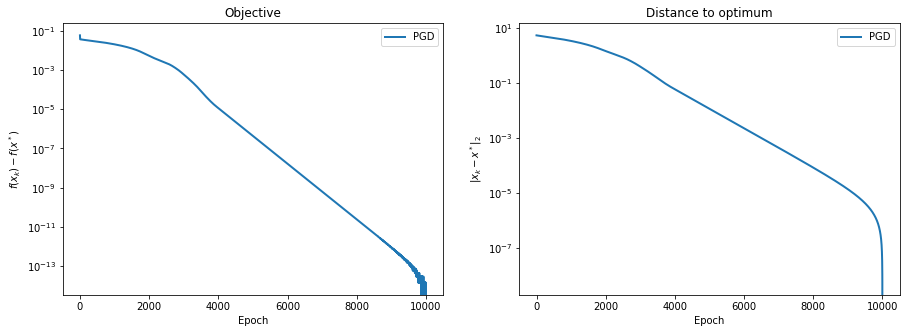

In [ ]:
# Generate bigger data
from sklearn.datasets import make_regression
from scipy.linalg import norm

X, y = make_regression(n_samples=500, n_features=100, random_state=0,
                       noise=4.0, bias=10.0)
n_samples, n_features = X.shape

# Set initial values of parameters to optimize
x_init = np.zeros(n_features + 1)
x_init[0] = np.mean(y)

n_iter = 10_000
lbda = 1
delta = 0.5
tau = 0.5

# TODO (implement function grad_smooth_pinball_loss and define step)

def grad_smooth_pinball_loss( *grad_args):
    X = grad_args[1]
    y = grad_args[2].reshape((-1,1))
    tau = grad_args[3]
    delta = grad_args[4]
    params = grad_args[0]

    w = params[1:].reshape((1,-1))
    b = params[0]

    residual = y - np.dot(X, w.T) - b
    g_pinball = grad_smooth_pinball(residual, tau, delta)  # gradient of the smoothed pinball loss

    
    g_w = -X.T@g_pinball / n_samples   # gradient of the objective function with respect to w
    g_b = -np.sum(g_pinball)/n_samples  # gradient of the objective function with respect to b
    return np.array(np.hstack((g_b, g_w.ravel())))  # return the gradient as a tuple

lipschitz_cte = norm(X.T@X, ord=2)  / (n_samples*delta)
step = 1/lipschitz_cte

# END TODO
grad_smooth_pinball_loss( x_init,X, y, tau, delta)
# Get a good x_min by letting the algorithm converge with many iterations
x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
               grad_args=(X, y,tau, delta), prox_args=(lbda,))

# Run PGD
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

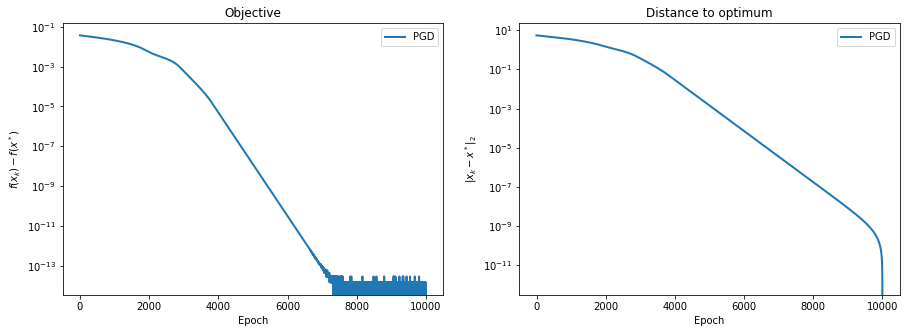

In [ ]:
# Run PGD for L1

x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

- we notice that the sparcity accelarates convergences. Obviously it starts slow and then becomes linear

QUESTION 8:
- Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.

In [ ]:
def apgd(x_init, grad, prox, step, n_iter=100, store_every=1,
         grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    x_new = x_init.copy()
    # An extra variable is required for APGD
    z = x_init.copy()
    t = 1.
    t_new = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(z - grad(z,*grad_args) * step, step, *prox_args )
        t_new = (1 + np.sqrt(1 + 4 * (t**2))) / 2
        z = x_new + (t - 1) * (x_new - x) / t_new

        x = x_new
        t = t_new


        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
            #print('Iteration :',i)
    return x, x_list

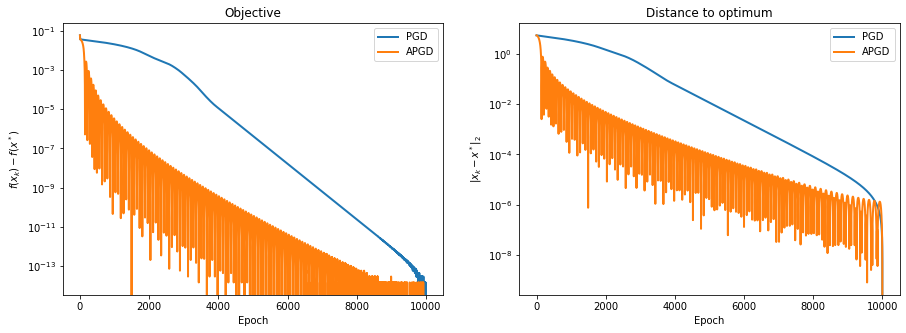

In [ ]:
# TODO
# Run APGD 
x_min, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
                grad_args=(X, y,tau, delta), prox_args=(lbda,))
# Run APGD
monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

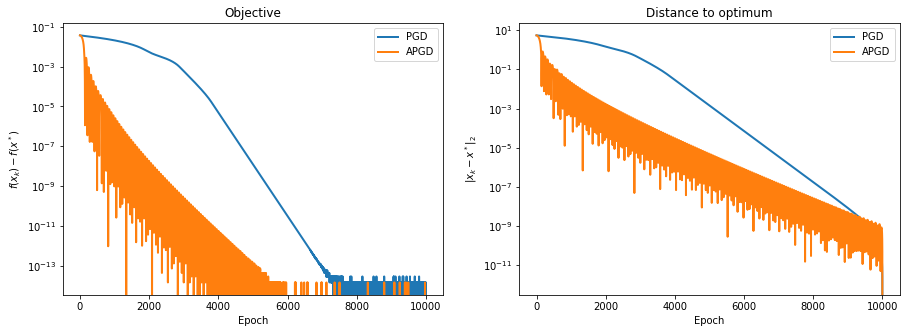

In [ ]:
# TODO
x_min_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

#### QUESTION 9
- Implement the proximal coordinate descent (PCD) and add this solver to the monitoring plots for L1 and L2 regularized models.

**Note:** You are welcome to try to use numba to get reasonable performance but don't spend too much time if you get weird numba errors.

In [ ]:
def prox_cd_R2(params, index, reg=1.):
    # TODO
    if index == 0 :
        b = params.copy()
        params = b
    else :
        w = params.copy()
        params = w/(1+2*reg)
    
    # END TODO
    return params


def prox_cd_R1(params, index, reg=1.):
    # TODO
    if index == 0 :
        b = params.copy()
        params = b
    else : 
        w = params.copy() 
        params = np.where(w>reg,w-reg,
                          np.where(w< -reg,w+reg,0))
    # END TODO
    return params


def prox_cd_l2(params, index ,step, lbda):
    return prox_cd_R2(params, index, reg=step * lbda)


def prox_cd_l1(params, index, step, lbda):
    return prox_cd_R1(params, index, reg=step * lbda)

In [ ]:
def proximal_cyclic_cd(x_init, grad, prox, step, n_iter=100,store_every=1,
        grad_args=(), prox_args=()):

    x = x_init.copy()
    x_list = []
    n_features = len(x_init)
    for t in range(n_iter):
        ### TODO
        j = t % n_features
        # Compute the gradient of the smooth data fitting term
        g = grad(x, *grad_args)

        # Compute the update for the parameters
        x[j] = prox(x[j] - step* g[j],j,step,*prox_args)
    
        if t % store_every == 0:
            x_list.append(x.copy())
            #print("Iteration", t)
    return x, x_list

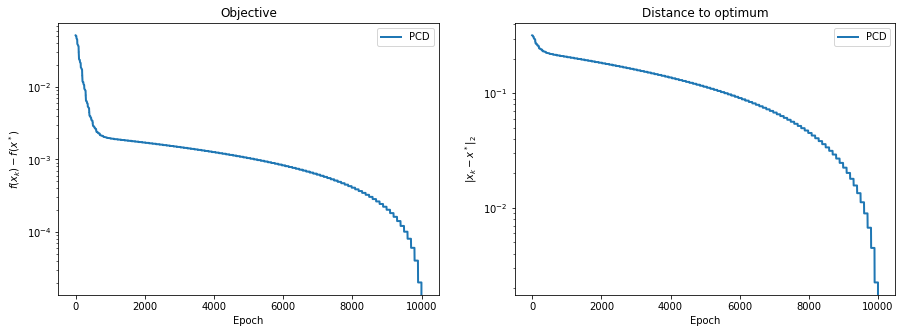

In [ ]:

# TODO
x_min_l2, _ = proximal_cyclic_cd(x_init, grad_smooth_pinball_loss, prox_cd_l2, step, n_iter=10000,store_every=1,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pcd_l2 = monitor(proximal_cyclic_cd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, tau, delta))
monitor_pcd_l2.run(x_init, grad_smooth_pinball_loss, prox_cd_l2, step, n_iter,store_every=1,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

# END TODO

monitors = [monitor_pcd_l2]
solvers = ["PCD"]
plot_epochs(monitors, solvers)

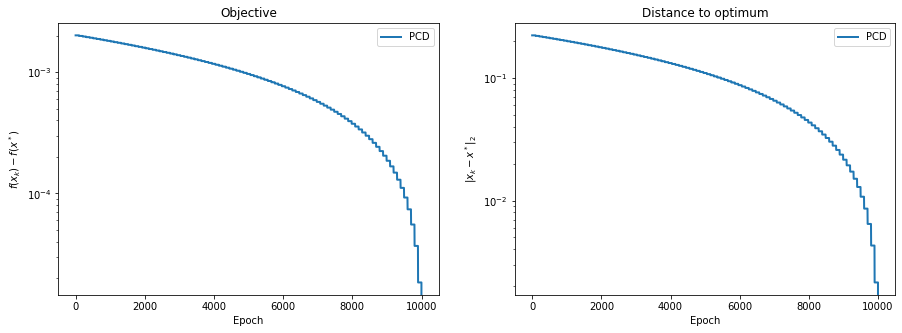

In [ ]:


# TODO
x_min_l1, _ = proximal_cyclic_cd(x_init, grad_smooth_pinball_loss, prox_cd_l1, step, n_iter=10000,store_every=1,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
monitor_pcd_l1 = monitor(proximal_cyclic_cd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
monitor_pcd_l1.run(x_init, grad_smooth_pinball_loss, prox_cd_l1, step, n_iter,store_every=1,
                   grad_args=(X, y, tau, delta), prox_args=(lbda,))

# END TODO

monitors = [monitor_pcd_l1]
solvers = ["PCD"]
plot_epochs(monitors, solvers)

#### QUESTION 10
- Compare the performance of the different solvers for different (simulated) problem sizes. You will test on a dataset with n_samples >> n_features, n_samples << n_features, and for high and low values of $\lambda$.
- What solver would you recommend for each of the 4 scenarios?

**Remark:** What is expected from you here is to provide clear and synthetic plots that show the performance of the different solvers for the different simulated datasets.

In [ ]:
from ipywidgets import interact, interact_manual
from ipywidgets import FloatSlider,Checkbox


In [ ]:
def function_plot(size_n_sup_m, lbda):
    
    X, y = make_regression(n_samples=500 if size_n_sup_m else 100 , n_features=100 if size_n_sup_m else 500, random_state=0,
                          noise=4.0, bias=10.0)
    n_samples, n_features = X.shape

    # Set initial values of parameters to optimize
    x_init = np.zeros(n_features + 1)
    x_init[0] = np.mean(y)

    n_iter = 10_000
    # lbda = 1
    delta = 0.5
    tau = 0.5

    # Run PGD for L2
    x_min, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
                  grad_args=(X, y,tau, delta), prox_args=(lbda,))

    
    monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
    monitor_pgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))
    
    #Run PGD for L1
    x_min_l1, _ = pgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
                  grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_pgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))

    x_min, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter=10000, store_every=1000,
                grad_args=(X, y,tau, delta), prox_args=(lbda,))
    # Run APGD
    monitor_apgd_l2 = monitor(apgd, pobj_l2, x_min, args=(X, y, lbda, tau, delta))
    monitor_apgd_l2.run(x_init, grad_smooth_pinball_loss, prox_l2, step, n_iter,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))

    x_min_l1, _ = apgd(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter=10000, store_every=1000,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_apgd_l1 = monitor(apgd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_apgd_l1.run(x_init, grad_smooth_pinball_loss, prox_l1, step, n_iter,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))

    # Run PCD
    x_min_l2, _ = proximal_cyclic_cd(x_init, grad_smooth_pinball_loss, prox_cd_l2, step, n_iter=10000,store_every=1,
                  grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pcd_l2 = monitor(proximal_cyclic_cd, pobj_l2, x_min=x_min_l2, args=(X, y, lbda, tau, delta))
    monitor_pcd_l2.run(x_init, grad_smooth_pinball_loss, prox_cd_l2, step, n_iter,store_every=1,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))

    x_min_l1, _ = proximal_cyclic_cd(x_init, grad_smooth_pinball_loss, prox_cd_l1, step, n_iter=10000,store_every=1,
               grad_args=(X, y, tau, delta), prox_args=(lbda,))
    monitor_pcd_l1 = monitor(proximal_cyclic_cd, pobj_l1, x_min=x_min_l1, args=(X, y, lbda, tau, delta))
    monitor_pcd_l1.run(x_init, grad_smooth_pinball_loss, prox_cd_l1, step, n_iter,store_every=1,
                      grad_args=(X, y, tau, delta), prox_args=(lbda,))

    monitors = [monitor_pgd_l1, monitor_pgd_l2, monitor_apgd_l1, monitor_apgd_l2, monitor_pcd_l1, monitor_pcd_l2]
    solvers = ["PGD L1","PGD L2","APGD L1","APGD L2","PCD L1","PCD L2"]
    plot_epochs(monitors, solvers)
    
    return True

### **$n > p$** :

$λ = 0.01$ :

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

$λ = 10$ :

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

As we can see in the case when $n>p$, the higher the term of regularization the fastest we converge to the optimum objective for almost all solvers except the coordiante descent where we are are generally on the same convergence rate to the optimum and optimal objective function. In this case the best solver is APGD, and specifically with $L_1$ penalization. Also, by varying $λ$ we observe that more is large the fast our solvers converge and that due to the coefficient of strong convexity that becomes more important.

### **$n < p$** :

$λ = 0.01$ :

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

$λ = 10 $ :

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

As we can see in the case when $n < p$, the higher the term of regularization the higher variance we got from APGD with Ridge, also the speed of convergence for PGD got worse. In this case, coordinate descent is better than PGD with both penalization terms. 

On another hand, even with small penalization the APGD solver is less performant compared to others in term of precision despite is faster, also it has a higher variance. The PGD is fast with ridge when $λ$ is small. 

In both cases, the precision of APGD is less than other solvers specifically Coordinates solvers.PCD is more accurate with different regularization terms but when $\lambda$ is small the PGD with L2 outperform PCD.

To summarize :

- For $\lambda $ large and n>p  the best solver is : APGD L1

- For $\lambda $ low and n>p  the best solver is : APGD L1

- For $\lambda $ large and n< p  the best solver is : APGD L1

- For $\lambda $ low and n< p  the best solver is : PGD L2 and and PCD with both penalization terms

### **Compare the two cases of $n>p$ and $n < p$ for $\lambda =1$ :**

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

In this case where $n > p$, the cost function is likely to be highly convex, which means that it has a single global minimum that is easy to find. Gradient descent solvers are well-suited to finding the global minimum of a highly convex cost function because they iteratively move towards the global minimum by taking small steps in the direction of the negative gradient.

We can see this through the graph above, all gradient descent solvers outperform proximal coordinate solvers.

In [ ]:
interact_manual(
    function_plot,size_n_sup_m=Checkbox(True), lbda=FloatSlider(min=0.01, max=10, step=0.09)
);

interactive(children=(Checkbox(value=True, description='size_n_sup_m'), FloatSlider(value=0.01, description='l…

In this case where $n < p$, it is generally better to use a solver that is based on coordinate descent, such as proximal coordinate gradient descent with lasso or proximal coordinate gradient descent with ridge regularization. In this case, the cost function is likely to be more complex and may have multiple local minima. Coordinate descent solvers are better suited to finding the global minimum of a complex cost function because they optimize one feature at a time, rather than all features simultaneously. As we can see, the coordiante method converge precisely compared to Apgd and faster than PGD.

# Part 3: Application

You will now apply your solver to some census dataset where we aim to predict the wage of a person give some demographic and work related variables.

**Disclaimer:** This dataset is not huge and regularization makes little sense with so little features but it serves as a simple illustration.

Let's first inspect the dataset:

In [ ]:
from sklearn.datasets import fetch_openml
wages = fetch_openml(name="cps_85_wages", as_frame=True)
X_df, y_df = wages["data"], wages["target"]
X_df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8.0,no,female,21.0,not_member,35.0,Hispanic,Other,Manufacturing,Married
1,9.0,no,female,42.0,not_member,57.0,White,Other,Manufacturing,Married
2,12.0,no,male,1.0,not_member,19.0,White,Other,Manufacturing,Unmarried
3,12.0,no,male,4.0,not_member,22.0,White,Other,Other,Unmarried
4,12.0,no,male,17.0,not_member,35.0,White,Other,Other,Married


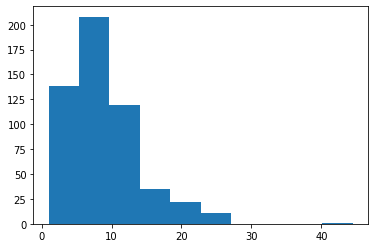

In [ ]:
plt.hist(y_df);

In [ ]:
X_df.dtypes

EDUCATION      float64
SOUTH         category
SEX           category
EXPERIENCE     float64
UNION         category
AGE            float64
RACE          category
OCCUPATION    category
SECTOR        category
MARR          category
dtype: object

Now let's extract `X` taking only the numerical columns (y is already defined above) and do some basic plot:

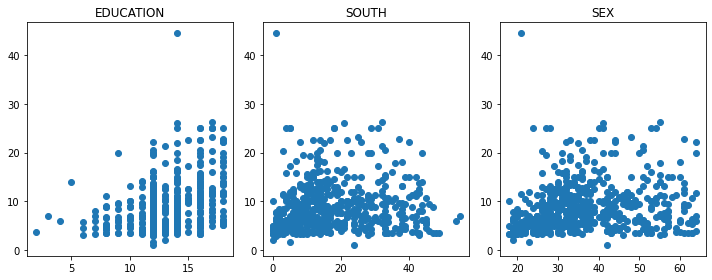

In [ ]:
X_df_num = X_df.select_dtypes(include=(float, int))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
for x, col_name, ax in zip(X_df_num.values.T, X_df.columns, axes.ravel()):
    ax.plot(x, y_df, 'o')
    ax.set_title(col_name)
fig.tight_layout()

In [ ]:
X = X_df_num.values
y = y_df.values
y.shape, X.shape

((534,), (534, 3))

We have now X and y!

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

#### QUESTION 11
- Implement the `fit` method from the estimator in the next cell and fit the model with the different solvers you implemented above.

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import scale


class SmoothQuantileRegressor(BaseEstimator, RegressorMixin):
    """scikit-learn estimator for regression with a smoothed quantile loss.
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    tau : float in (0, 1)
        The quantile to predict.
    delta : float
        The smoothing parameter.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'pcd'
        The type of algorithm to use.
        
    Attributes
    ----------
    coef_ : ndarray, (n_features,)
        The weitghs w.
    intercept_ : float
        The intercept or bias term b.
    """
    def __init__(self, lbda=1., penalty='l2', tau=0.5, delta=0.5,
                 max_iter=2000, solver='pgd'):
        self.lbda = lbda
        self.penalty = penalty
        self.tau = tau
        self.delta = delta
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'pcd'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
        """
        n_samples, n_features = X.shape
        # TODO
        x_init = np.zeros(n_features + 1)
        x_init[0] = np.mean(y)

        lipschitz_cte = norm(X.T@X, ord=2)  / (n_samples*delta)
        step = 1/lipschitz_cte

        if self.solver == 'pgd':
            x,_ = pgd(x_init, grad_smooth_pinball_loss, eval("prox_"+self.penalty), step, n_iter=self.max_iter, store_every=1,
               grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))

        elif self.solver == 'apgd':
            x,_ = apgd(x_init, grad_smooth_pinball_loss, eval("prox_"+self.penalty), step, n_iter=self.max_iter, store_every=1,
               grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))

        elif self.solver == 'pcd':
            x,_ = proximal_cyclic_cd(x_init, grad_smooth_pinball_loss, eval("prox_cd_"+self.penalty), step, n_iter=self.max_iter,store_every=1,
                      grad_args=(X, y, self.tau, self.delta), prox_args=(self.lbda,))
            
  
        # END TODO
        self.params_ = x
        self.coef_ = x[1:]
        self.intercept_ = x[0]
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.dot(X, self.coef_) + self.intercept_

    
    def score(self, X, y):
        """Score using the pinball loss.
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target.
            
        Returns
        -------
        score : float
            The negative pinball loss.
            Negative to keep the semantic that higher is better.
        """
        return -np.mean(pinball(y - self.predict(X), tau=self.tau))

lbda = 1e-4
max_iter = 1000

X_scaled = scale(X)  # standardize the features

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L2: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

for solver in ['pgd', 'apgd', 'pcd']:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l1', max_iter=max_iter, solver=solver)
    clf.fit(X_scaled, y)
    print('Solver with L1: %s   \t-   Pinball : %.5f' % (solver, -clf.score(X, y)))

Solver with L2: pgd   	-   Pinball : 34.62548
Solver with L2: apgd   	-   Pinball : 28.90179
Solver with L2: pcd   	-   Pinball : 34.65972
Solver with L1: pgd   	-   Pinball : 34.68066
Solver with L1: apgd   	-   Pinball : 14.80147
Solver with L1: pcd   	-   Pinball : 34.67990


To illustrate the predicitons here is a simple plot where you should see the interval of the predictions with 3 different quantiles. Feel free to comment on what you see and go beyond this plot if you feel inspired !

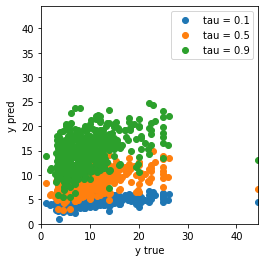

In [ ]:
fig, ax = plt.subplots()
for tau in [0.1, 0.5, 0.9]:
    clf = SmoothQuantileRegressor(lbda=lbda, penalty='l2', solver="apgd", tau=tau)
    y_pred = clf.fit(X_scaled, y).predict(X_scaled)
    ax.plot(y, y_pred, 'o', label=f'tau = {tau:.1f}')
    ax.axis("square")

ax.set(xlabel="y true", ylabel="y pred", xlim=(0, np.max(y)), ylim=(0, np.max(y)))
plt.legend();